# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


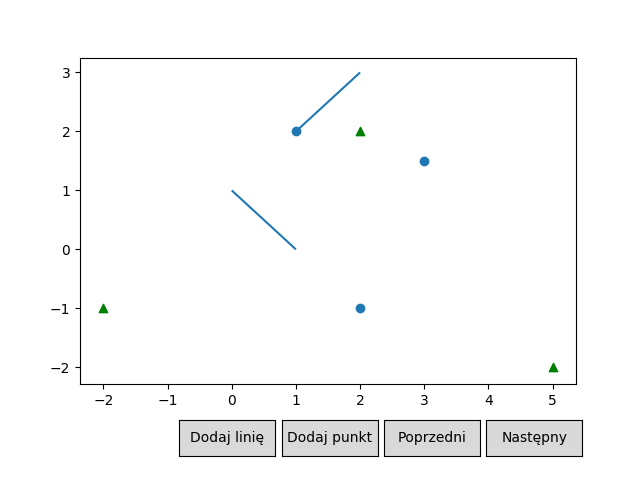

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


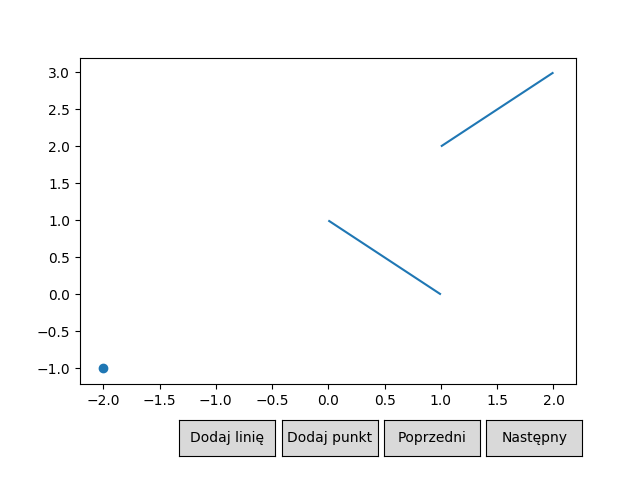

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


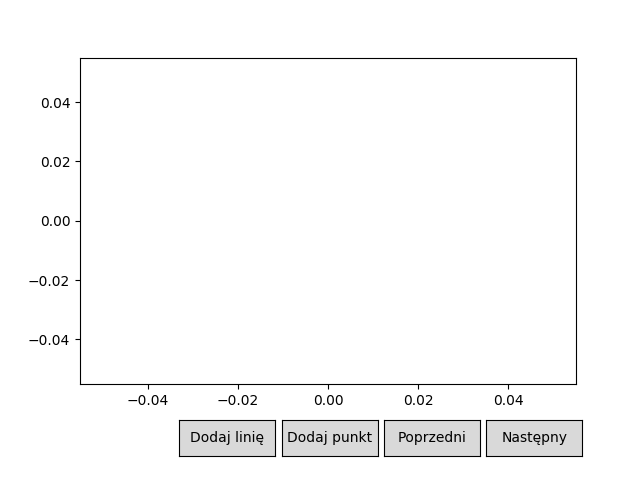

In [5]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


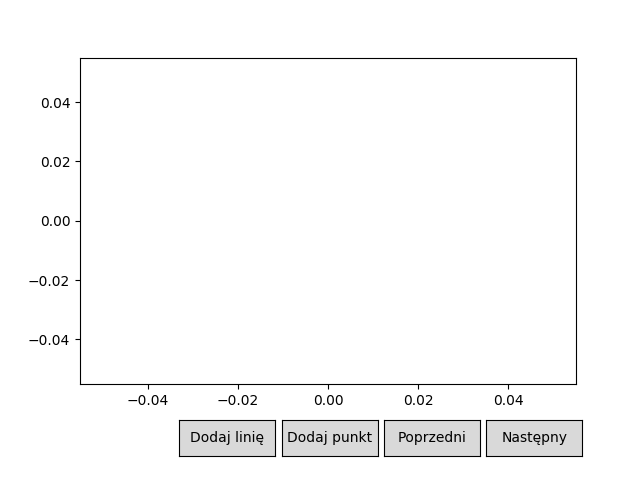

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

In [8]:
# import sys
# !{sys.executable} -m pip install bintrees

### Rozwiązanie

In [57]:
import random
import heapq
import bintrees # do działanie należy wpisać 'pip install bintrees' w wierszu polecenia i włączyć jeszcze raz jupyter noteebok 
%matplotlib notebook

eps = 10**(-14)

scenes = []

def random_lines(number, range_x, range_y):
    lines = []
    once_more = True
    while once_more:
        points = []
        for i in range(2*number):
            points.append((random.random() * (range_x[1] - range_x[0]) + range_x[0],
                           random.random() * (range_y[1] - range_y[0]) + range_y[0]))

        for i in range(number):
            line_s, line_e = min(points[2*i], points[2*i+1]), max(points[2*i], points[2*i+1])
            lines.append([line_s, line_e])

        points.sort()

        once_more = False
        for i in range(2*number - 1):
            if points[i] == points[i+1]:
                once_more = True
                break
    
    return lines

def make_linear_func(p1, p2): # zwraca parametry funkcji liniowej, która zawiera odcinek (p1,p2)
    p2, p1 = max(p1, p2), min(p1, p2)
    
    if p2[1] == p1[1]: # pionowy odcinek
        return None
    
    a = (p2[1]-p1[1]) / (p2[0]-p1[0])  # współczynnik kierunkowy
    b = p1[1] - ((p2[1]-p1[1]) * p1[0]) / (p2[0]-p1[0]) # wyraz wolny
    
    return (a, b)

def point_on_line(point_x, line):  # sprawdza czy punkt leży na odcinku czy tylko na jego przedłużeniu
    line = (min(line[0], line[1]), max(line[0], line[1])) # porządkuje punkty odcinka rosnąco (najpierw po x potem po y)
    
    return point_x >= line[0][0] and point_x <= line[1][0] # wystarczy sprawdzić 1 współrzędną
    

def find_intersection(l1, l2): # zwraca przecięcie lub None jeśli go nie ma
    l1_f = make_linear_func(l1[0], l1[1])
    l2_f = make_linear_func(l2[0], l2[1])
    
    # punkt przecięcia
    inter_x = (l2_f[1] - l1_f[1]) / (l1_f[0] - l2_f[0])
    inter_y = l1_f[0] * inter_x + l1_f[1]
    
    # czy punkt leży na odcinkach czy tylko na przedłużeniach
    if point_on_line(inter_x, l1) and point_on_line(inter_x, l2):
        return (inter_x, inter_y)
    else:
        return None        
        

def draw_step(lines, curr_event): # wizualizacja kroku algorytmu
    # chcemy zaznaczyć na czerwono punkt w którym ma miejsce obecne zdarzenie
    if curr_event[1] == 's':
        highlighted_point = curr_event[2][0][0]
    elif curr_event[1] == 'e':
        highlighted_point = curr_event[2][0][1]
    else:
        highlighted_point = find_intersection(curr_event[2][0], curr_event[2][1])

    # chcemy narysować miotłę
    broom = [(highlighted_point[0], 0), (highlighted_point[0], 10)]
    
    # dodanie sceny z obecnej iteracji algorytmu
    scenes.append(Scene([PointsCollection([highlighted_point], color='red')], 
                        [LinesCollection(lines, color='blue'), LinesCollection([broom], color='red')]))


<IPython.core.display.Javascript object>


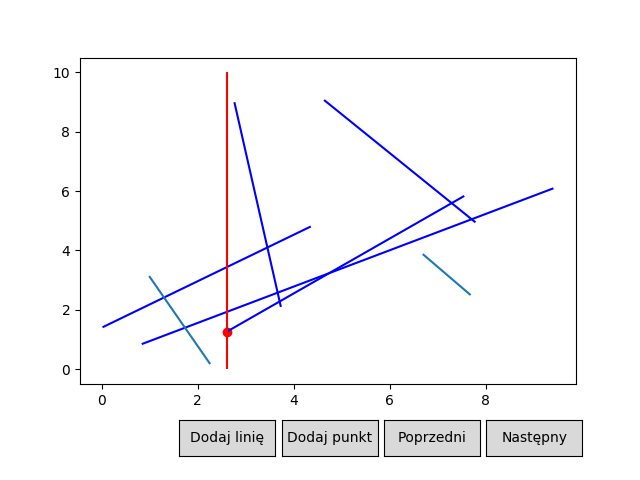

In [63]:
def sweep_line_algorithm_bool(lines, visualization=False):
    events = [] # lista krotek z trzema wartościami: x-owa współrzędna; typ zdarzenia 
                # ('s'-początek odcinka, 'e'-koniec odcinka); odcinek biorący udział (potrzebny do wizualizacji)
        
    state = bintrees.RBTree() # drzewo czerono-czarne będące strukturą stanu
        
    for line in lines:
        events.append((line[0][0], 's', [line]))
        events.append((line[1][0], 'e', [line]))
    
    events.sort()
    for x, e_type, [line] in events:
        if visualization:
            draw_step(lines, (x, e_type, [line]))
            
        if e_type == 's':
            state.insert(line[0][1], line)
            
            try: # RBTree zwraca błąd gdy nie znajdzie poprzednika lub następnika 
                prev = state.prev_item(line[0][1])
                if find_intersection(line, prev[1]) is not None:
                    if visualization:
                        draw_step(lines, (find_intersection(line, prev[1])[0], 'i', [line, prev[1]]))
                    return True
            except:
                pass
            
            try:
                succ = state.succ_item(line[0][1])
                if find_intersection(line, succ[1]) is not None:
                    if visualization:
                        draw_step(lines, (find_intersection(line, succ[1])[0], 'i', [line, succ[1]]))
                    return True
            except:
                pass
            
        elif e_type == 'e':
            try:
                prev = state.prev_item(line[0][1])
                succ = state.succ_item(line[0][1])
                
                if find_intersection(prev[1], succ[1]) is not None:
                    if visualization:
                        draw_step(lines, (find_intersection(prev[1], succ[1])[0], 'i', [prev[1], succ[1]]))
                    return True
            except:
                pass
        
            state.remove(line[0][1])
    
    return False

scenes = []

lines = random_lines(5, (0,10), (0, 10))

sweep_line_algorithm_bool(lines, visualization=True)

plot = Plot(scenes)
plot.draw()

1.00000000000001
1.0
RBTree({2: 'e', 3: 'd'})


<IPython.core.display.Javascript object>


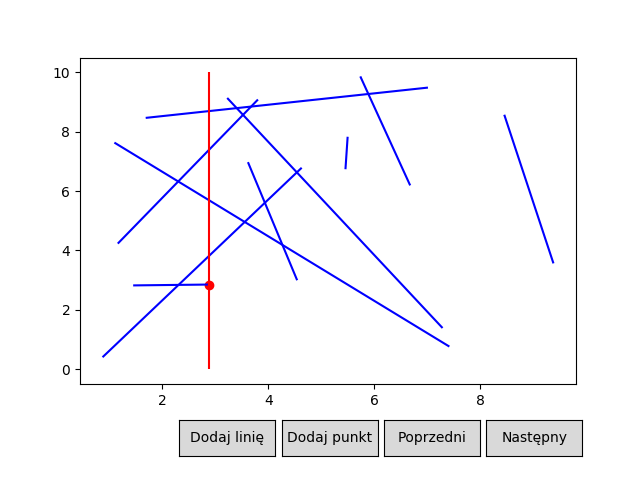

In [66]:
def sweep_line_algorithm(lines, visualization=False):
    events = [] # kopiec minimum krotek z trzema wartościami: x-owa współrzędna; typ zdarzenia 
                # ('s'-początek odcinka, 'e'-koniec odcinka, 'i'-przecięcie odcinków); odcinki biorące udział
        
    state = bintrees.RBTree()  # drzewo czerono-czarne będące strukturą stanu
    
    intersections = [] # drzewo czerono-czarne przecięć, by sprawdzić czy dane przecięcie już było brane pod uwagę
    
    for line in lines:
        heapq.heappush(events, (line[0][0], 's', [line]))
        heapq.heappush(events, (line[1][0], 'e', [line]))
    
    events.sort()
    
    while len(events) > 0:
        (x, e_type, [line]) = heapq.heappop(events)
        
        if visualization:
            draw_step(lines, (x, e_type, [line]))
            
        if e_type == 's':
            state.insert(line[0][1], line)
            
            try:
                prev = state.prev_item(line[0][1])
                
                intersection = find_intersection(line, prev[1])
                if intersection is not None:
                    heap.heappush(events, (intersection[0], 'i', [prev[1], line]))
                    
                    intersections.insert(intersection[0], [prev[1], line])
            except:
                pass
            
            try:
                succ = state.succ_item(line[0][1])
                
                intersection = find_intersection(line, prev[1])
                if intersection is not None:
                    heap.heappush(events, (intersection[0], 'i', [line, succ[1]]))
                    
                    intersections.insert(intersection[0], [line, succ[1]])
            except:
                pass
            
        elif e_type == 'e':
            try:
                prev = state.prev_item(line[0][1])
                succ = state.succ_item(line[0][1])
                
                intersection = find_intersection(prev[1], succ[1])
                if intersection is not None:
                    try:
                        intersections.get_item(intersection[0])
                    except:
                        heap.heappush(events, (intersection[0], 'i', [prev[1], succ[1]]))
                
                        intersections.insert(intersection[0], [prev[1], succ[1]])
                    
            except:
                pass
        
            state.remove(line[0][1])
            
        elif e_type == 'i':
            pass
    
    return intersections

scenes = []

x = 1.0
eps = 10**(-14)
print(x+eps)
print(x)
print(tree)

lines = random_lines(10, (0, 10), (0, 10))

sweep_line_algorithm(lines, visualization=True)

plot = Plot(scenes)
plot.draw()